<a href="https://colab.research.google.com/github/WtXXxxxww/DS_sample/blob/main/DSA5205_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===================================================================
# Import Libraries
# ===================================================================
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random # New import

# --- Set global random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
# -----------------------------------------

%matplotlib inline

In [2]:
# ===================================================================
# --- 1. Set Strategy Parameters ---
# ===================================================================

# Use 15 well-known large-cap tech stocks as the stock pool
tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META",
    "TSLA", "AVGO", "ASML", "ORCL", "CRM", "AMD",
    "QCOM", "INTC", "IBM"
]
start_date = "2018-01-01"
end_date = "2024-10-01"
rebalance_freq = "ME" # Changed from "M" to "ME" for modern pandas
top_n_quintile = 0.2
TRAIN_WINDOW = 36 # Use the past 36 months of data as a rolling training window

In [3]:
# ===================================================================
# --- 2. Data Fetching ---
# ===================================================================

print("Starting to download price data...")
price_data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']

monthly_prices = price_data.resample(rebalance_freq).last()
print("Price data download complete.")
monthly_prices.head()

Starting to download price data...


/tmp/ipython-input-3780818894.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']


Price data download complete.


Ticker,AAPL,AMD,AMZN,ASML,AVGO,CRM,GOOGL,IBM,INTC,META,MSFT,NVDA,ORCL,QCOM,TSLA
Date,,,,,,,,,,,,,,,
2018-01-31,39.248745,13.74,72.544502,187.910339,19.666399,112.724243,58.706100,110.982635,40.413345,185.744919,87.546623,6.077255,45.937904,55.712090,23.620667
2018-02-28,41.924927,12.11,75.622498,180.901688,19.541908,115.039879,54.817921,106.687210,41.659477,177.227463,86.809921,5.987020,45.118690,53.514549,22.870667
2018-03-31,39.491150,10.05,72.366997,183.836639,18.958567,115.089371,51.501785,105.044090,44.017574,158.810974,84.495499,5.729481,40.737713,45.619102,17.742001
2018-04-30,38.898010,10.88,78.306503,176.021683,18.457352,119.730545,50.580143,99.245178,43.628777,170.946167,86.578468,5.563971,40.834850,41.996574,19.593332
2018-05-31,44.154057,13.73,81.481003,183.680908,20.279596,127.983711,54.623257,97.820229,46.923828,190.604980,91.900208,6.242977,41.773685,48.350182,18.982000


In [8]:
# ===================================================================
# --- 3. Factor Calculation ---
# ===================================================================

def get_book_to_price(tickers):
    """
    Use yfinance to get the book-to-price (B/P) ratio for the stock pool.
    Note: yfinance provides the latest P/B, this is a simplified approach.
    """
    b2p_data = {}
    print("Starting to fetch value factor data (Book-to-Price)...")
    for ticker in tickers:
        try:
            info = yf.Ticker(ticker).info
            pb_ratio = info.get('priceToBook')
            if pb_ratio is not None:
                b2p_data[ticker] = 1 / pb_ratio
            else:
                b2p_data[ticker] = np.nan # Missing data
        except Exception as e:
            print(f"Failed to fetch data for {ticker}: {e}")
            b2p_data[ticker] = np.nan
    print("Value factor data fetching complete.")
    return pd.Series(b2p_data)

def get_market_cap(tickers):
    """
    Use yfinance to get the total market capitalization for the stock pool.
    """
    market_cap_data = {}
    print("Starting to fetch size factor data (Market Cap)...")
    for ticker in tickers:
        try:
            info = yf.Ticker(ticker).info
            market_cap = info.get('marketCap')
            if market_cap is not None:
                market_cap_data[ticker] = np.log(market_cap) # Apply logarithm
            else:
                market_cap_data[ticker] = np.nan
        except Exception as e:
            print(f"Failed to fetch market cap for {ticker}: {e}")
            market_cap_data[ticker] = np.nan
    print("Size factor data fetching complete.")
    return pd.Series(market_cap_data)

def calculate_factors(data, tickers):
    """
    Calculate multiple factors such as momentum, value, volatility, size, and short-term reversal.
    """
    # 1. Momentum Factor
    momentum = data.pct_change(11).shift(1)

    # 2. Value Factor (Value - B/P)
    book_to_price_series = get_book_to_price(tickers)
    value_factor = pd.DataFrame(index=data.index, columns=data.columns)
    for ticker in data.columns:
        value_factor[ticker] = book_to_price_series.get(ticker, np.nan)

    # 3. Volatility Factor: Standard deviation of the past 6 months' returns
    volatility = data.pct_change().rolling(window=6).std().shift(1)

    # 4. Size Factor: Logarithm of total market cap
    market_cap_series = get_market_cap(tickers)
    size_factor = pd.DataFrame(index=data.index, columns=data.columns)
    for ticker in data.columns:
        size_factor[ticker] = market_cap_series.get(ticker, np.nan)

    # 5. Short-term Reversal Factor: Last month's return
    reversal = data.pct_change(1).shift(1)

    # Put all factors into a dictionary for easy management
    factors = {
        'momentum': momentum,
        'value': value_factor,
        'volatility': volatility,
        'size': size_factor,
        'reversal': reversal
    }

    return factors

print("Starting to calculate all factors (final enhanced version)...")
all_factors = calculate_factors(monthly_prices, tickers)
print("All factor calculations complete.")

Starting to calculate all factors (final enhanced version)...
Starting to fetch value factor data (Book-to-Price)...
Value factor data fetching complete.
Starting to fetch size factor data (Market Cap)...
Size factor data fetching complete.
All factor calculations complete.


In [9]:
# ===================================================================
# --- 4: Backtesting Function Integrating All Information
# ===================================================================

def backtest_strategy_final(prices, factors, training_window, transaction_cost=0.001):
    """
    Execute a full backtest, recording returns, turnover, predicted values, and actual values.
    """
    monthly_returns = prices.pct_change()
    portfolio_returns = pd.Series(index=prices.index, dtype=float)
    param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 500.0]}
    factor_names = list(factors.keys())

    # --- New: Lists to record predicted and actual values ---
    predictions_list = []
    actuals_list = []

    previous_selection = set()
    turnover_list = []

    for i in range(training_window, len(prices)):
        decision_date = prices.index[i-1]
        prediction_month_start = prices.index[i]
        train_start = prices.index[i - training_window]
        train_end = decision_date

        print(f"Rolling Window: {train_start.strftime('%Y-%m')} to {train_end.strftime('%Y-%m')}")

        # Prepare training data
        stacked_factors = [factors[name].loc[train_start:train_end].stack(future_stack=True).rename(name) for name in factor_names]
        X_train = pd.concat(stacked_factors, axis=1)
        y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
        y_train = y_train_raw.loc[X_train.index]
        train_data = pd.concat([X_train, y_train.rename('target')], axis=1).dropna()

        if len(train_data) < 100:
            portfolio_returns.loc[prediction_month_start] = 0
            if i > training_window: turnover_list.append(0)
            continue

        X_train_clean, y_train_clean = train_data[factor_names], train_data['target']
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_clean)

        # Model training
        tscv = TimeSeriesSplit(n_splits=3)
        grid_search = GridSearchCV(estimator=Ridge(random_state=42), param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_scaled, y_train_clean)
        best_model = grid_search.best_estimator_
        print(f"  -> Optimal Alpha: {grid_search.best_params_['alpha']}")

        # Prepare current period prediction data
        pred_factors = [factors[name].loc[decision_date].rename(name) for name in factor_names]
        X_pred_raw = pd.concat(pred_factors, axis=1).dropna()

        if X_pred_raw.empty:
            portfolio_returns.loc[prediction_month_start] = 0
            if i > training_window: turnover_list.append(0)
            previous_selection = set()
            continue

        X_pred_scaled = scaler.transform(X_pred_raw)
        predicted_returns = pd.Series(best_model.predict(X_pred_scaled), index=X_pred_raw.index)

        # --- New: Record predicted values and corresponding actual returns for all stocks ---
        # Actual return is the next month's return
        actual_period_returns = monthly_returns.loc[prediction_month_start]
        # Align predictions and actuals
        aligned_preds = predicted_returns.reindex(actual_period_returns.index)

        # Store current period data in lists
        predictions_list.append(aligned_preds.rename(prediction_month_start))
        actuals_list.append(actual_period_returns.rename(prediction_month_start))

        # Stock selection
        num_to_select = int(len(predicted_returns) * top_n_quintile)
        selected_stocks = predicted_returns.nlargest(max(1, num_to_select)).index

        # Turnover calculation
        current_selection = set(selected_stocks)
        if previous_selection:
            stocks_traded = len((previous_selection - current_selection) | (current_selection - previous_selection))
            turnover = stocks_traded / (len(previous_selection) + len(current_selection))
            turnover_list.append(turnover)
        else:
            turnover_list.append(1.0)
        previous_selection = current_selection

        # Calculate return and deduct costs
        period_return = monthly_returns.loc[prediction_month_start, selected_stocks].mean()
        cost_impact = turnover_list[-1] * transaction_cost
        net_return = period_return - cost_impact
        portfolio_returns.loc[prediction_month_start] = net_return

    # --- Consolidate all results into a DataFrame ---
    results = pd.DataFrame({'ML_Strategy': portfolio_returns.fillna(0)})

    # This was missing in the original code but needed for the performance evaluation
    if turnover_list:
        turnover_series = pd.Series(turnover_list, index=prices.index[training_window:len(prices)], name='Monthly_Turnover')
        results = results.join(turnover_series)

    # Convert prediction and actual value lists to DataFrames
    predictions_df = pd.concat(predictions_list, axis=1).T
    actuals_df = pd.concat(actuals_list, axis=1).T

    return results, predictions_df, actuals_df

In [10]:
# ===================================================================
# --- 5: Execute Backtest and Consolidate All Data
# ===================================================================

print("--- Starting Strategy Backtest (Recording All Information) ---")

# 1. Execute backtest, now receiving three outputs
backtest_results_ml, predictions_df, actuals_df = backtest_strategy_final(
    monthly_prices, all_factors, TRAIN_WINDOW, transaction_cost=0.001
)

# 2. Download and prepare SPY benchmark data
rebalance_freq = "ME"
print("\nDownloading benchmark data (SPY)...")
spy_data = yf.download("SPY", start=start_date, end=end_date, progress=False)['Close']
spy_monthly_returns = spy_data.resample(rebalance_freq).last().pct_change()
spy_monthly_returns.name = "SPY"
print("Benchmark data download complete.")

# 3. Merge the results
backtest_results_ml = backtest_results_ml.join(spy_monthly_returns)

print("\n--- Backtest Execution Complete, Final Results Preview ---")
backtest_results_ml.tail()


--- Starting Strategy Backtest (Recording All Information) ---
Rolling Window: 2018-01 to 2020-12
  -> Optimal Alpha: 500.0
Rolling Window: 2018-02 to 2021-01
  -> Optimal Alpha: 500.0
Rolling Window: 2018-03 to 2021-02


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warnin

  -> Optimal Alpha: 500.0
Rolling Window: 2018-04 to 2021-03
  -> Optimal Alpha: 500.0
Rolling Window: 2018-05 to 2021-04
  -> Optimal Alpha: 500.0
Rolling Window: 2018-06 to 2021-05


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warnin

  -> Optimal Alpha: 500.0
Rolling Window: 2018-07 to 2021-06
  -> Optimal Alpha: 500.0
Rolling Window: 2018-08 to 2021-07
  -> Optimal Alpha: 500.0
Rolling Window: 2018-09 to 2021-08


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warnin

  -> Optimal Alpha: 500.0
Rolling Window: 2018-10 to 2021-09
  -> Optimal Alpha: 500.0
Rolling Window: 2018-11 to 2021-10
  -> Optimal Alpha: 500.0
Rolling Window: 2018-12 to 2021-11


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warnin

  -> Optimal Alpha: 500.0
Rolling Window: 2019-01 to 2021-12
  -> Optimal Alpha: 500.0
Rolling Window: 2019-02 to 2022-01
  -> Optimal Alpha: 500.0
Rolling Window: 2019-03 to 2022-02


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warnin

  -> Optimal Alpha: 500.0
Rolling Window: 2019-04 to 2022-03
  -> Optimal Alpha: 500.0
Rolling Window: 2019-05 to 2022-04
  -> Optimal Alpha: 500.0
Rolling Window: 2019-06 to 2022-05


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warnin

  -> Optimal Alpha: 500.0
Rolling Window: 2019-07 to 2022-06
  -> Optimal Alpha: 500.0
Rolling Window: 2019-08 to 2022-07
  -> Optimal Alpha: 500.0
Rolling Window: 2019-09 to 2022-08


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warnin

  -> Optimal Alpha: 500.0
Rolling Window: 2019-10 to 2022-09
  -> Optimal Alpha: 500.0
Rolling Window: 2019-11 to 2022-10
  -> Optimal Alpha: 500.0
Rolling Window: 2019-12 to 2022-11


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warnin

  -> Optimal Alpha: 500.0
Rolling Window: 2020-01 to 2022-12
  -> Optimal Alpha: 500.0
Rolling Window: 2020-02 to 2023-01
  -> Optimal Alpha: 500.0
Rolling Window: 2020-03 to 2023-02


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warnin

  -> Optimal Alpha: 500.0
Rolling Window: 2020-04 to 2023-03
  -> Optimal Alpha: 500.0
Rolling Window: 2020-05 to 2023-04
  -> Optimal Alpha: 500.0
Rolling Window: 2020-06 to 2023-05


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warnin

  -> Optimal Alpha: 500.0
Rolling Window: 2020-07 to 2023-06
  -> Optimal Alpha: 500.0
Rolling Window: 2020-08 to 2023-07
  -> Optimal Alpha: 500.0
Rolling Window: 2020-09 to 2023-08


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)


  -> Optimal Alpha: 500.0
Rolling Window: 2020-10 to 2023-09
  -> Optimal Alpha: 500.0
Rolling Window: 2020-11 to 2023-10


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)


  -> Optimal Alpha: 500.0
Rolling Window: 2020-12 to 2023-11
  -> Optimal Alpha: 500.0
Rolling Window: 2021-01 to 2023-12


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)


  -> Optimal Alpha: 500.0
Rolling Window: 2021-02 to 2024-01
  -> Optimal Alpha: 500.0
Rolling Window: 2021-03 to 2024-02


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)


  -> Optimal Alpha: 500.0
Rolling Window: 2021-04 to 2024-03
  -> Optimal Alpha: 500.0
Rolling Window: 2021-05 to 2024-04


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)


  -> Optimal Alpha: 500.0
Rolling Window: 2021-06 to 2024-05
  -> Optimal Alpha: 500.0
Rolling Window: 2021-07 to 2024-06


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)


  -> Optimal Alpha: 500.0
Rolling Window: 2021-08 to 2024-07
  -> Optimal Alpha: 500.0
Rolling Window: 2021-09 to 2024-08


/tmp/ipython-input-1430249816.py:32: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_train_raw = monthly_returns.stack(dropna=False).shift(-1)
/tmp/ipython-input-833187630.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", start=start_date, end=end_date, progress=False)['Close']


  -> Optimal Alpha: 500.0

Benchmark data download complete.

--- Backtest Execution Complete, Final Results Preview ---


,ML_Strategy,Monthly_Turnover,SPY
Date,,,
2024-05-31,0.056347,0.333333,0.050580
2024-06-30,0.053235,0.666667,0.035280
2024-07-31,0.024782,0.666667,0.012109
2024-08-31,0.051827,1.000000,0.023366
2024-09-30,0.048701,0.666667,0.021004



--- Strategy Performance Evaluation (Final Version) ---

Backtest Period: 2021-01-31 to 2024-09-30
                      ML_Strategy      SPY
Total Return               1.2189   0.6194
Annualized Return          0.2368   0.1372
Annualized Volatility      0.3027   0.1631
Sharpe Ratio               0.7824   0.8411
Max Drawdown              -0.4121  -0.2393
Annualized Turnover        7.8222   0.0000

-----------------------



/tmp/ipython-input-3466742699.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(metrics.applymap(lambda x: f"{x:.4f}")) # Format output


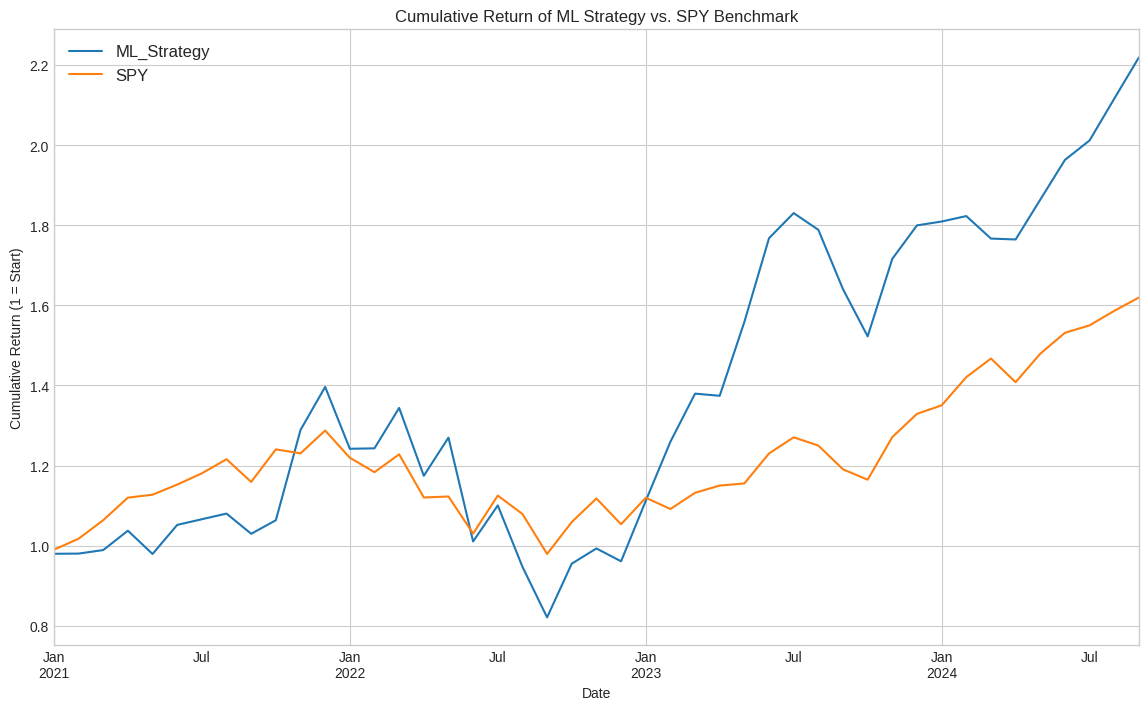

In [11]:
# ===================================================================
# --- 6: Performance Evaluation and Visualization
# ===================================================================

def evaluate_performance_final(results, training_window):
    """
    Calculate and print all key metrics including turnover and max drawdown, and plot charts.
    """
    # Slice the effective backtest period and handle missing values
    effective_results = results.iloc[training_window:].copy()
    effective_results.fillna(0, inplace=True)

    # Separate returns and turnover data
    returns_df = effective_results.rename(columns={'SPY_Benchmark': 'SPY'})
    returns_data = returns_df[['ML_Strategy', 'SPY']]
    turnover_data = effective_results.get('Monthly_Turnover')

    cumulative_results = (1 + returns_data).cumprod()

    # --- Key Performance Indicator Calculation ---
    total_return = cumulative_results.iloc[-1] - 1
    effective_months = len(returns_data)
    annualized_return = (cumulative_results.iloc[-1]) ** (12 / effective_months) - 1
    annualized_volatility = returns_data.std() * np.sqrt(12)
    sharpe_ratio = annualized_return / annualized_volatility.replace(0, np.nan)

    # Max Drawdown
    running_max = cumulative_results.cummax()
    drawdown = (cumulative_results - running_max) / running_max
    max_drawdown = drawdown.min()

    # Annualized Turnover
    avg_monthly_turnover = turnover_data.mean() if turnover_data is not None else 0
    annualized_turnover = avg_monthly_turnover * 12

    print("\n--- Strategy Performance Evaluation (Final Version) ---\n")
    print(f"Backtest Period: {returns_data.index.min().strftime('%Y-%m-%d')} to {returns_data.index.max().strftime('%Y-%m-%d')}")

    metrics = pd.DataFrame({
        "ML_Strategy": [total_return['ML_Strategy'], annualized_return['ML_Strategy'], annualized_volatility['ML_Strategy'], sharpe_ratio['ML_Strategy'], max_drawdown['ML_Strategy'], annualized_turnover],
        "SPY": [total_return['SPY'], annualized_return['SPY'], annualized_volatility['SPY'], sharpe_ratio['SPY'], max_drawdown['SPY'], 0.0] # Benchmark turnover is 0
    }, index=["Total Return", "Annualized Return", "Annualized Volatility", "Sharpe Ratio", "Max Drawdown", "Annualized Turnover"])

    print(metrics.applymap(lambda x: f"{x:.4f}")) # Format output
    print("\n-----------------------\n")

    # --- Plotting Charts ---
    plt.style.use('seaborn-v0_8-whitegrid')
    cumulative_results.plot(
        figsize=(14, 8),
        title='Cumulative Return of ML Strategy vs. SPY Benchmark'
    )
    plt.ylabel('Cumulative Return (1 = Start)')
    plt.xlabel('Date')
    plt.legend(fontsize=12)
    plt.show()

evaluate_performance_final(backtest_results_ml, TRAIN_WINDOW)


--- Plotting Additional Charts ---


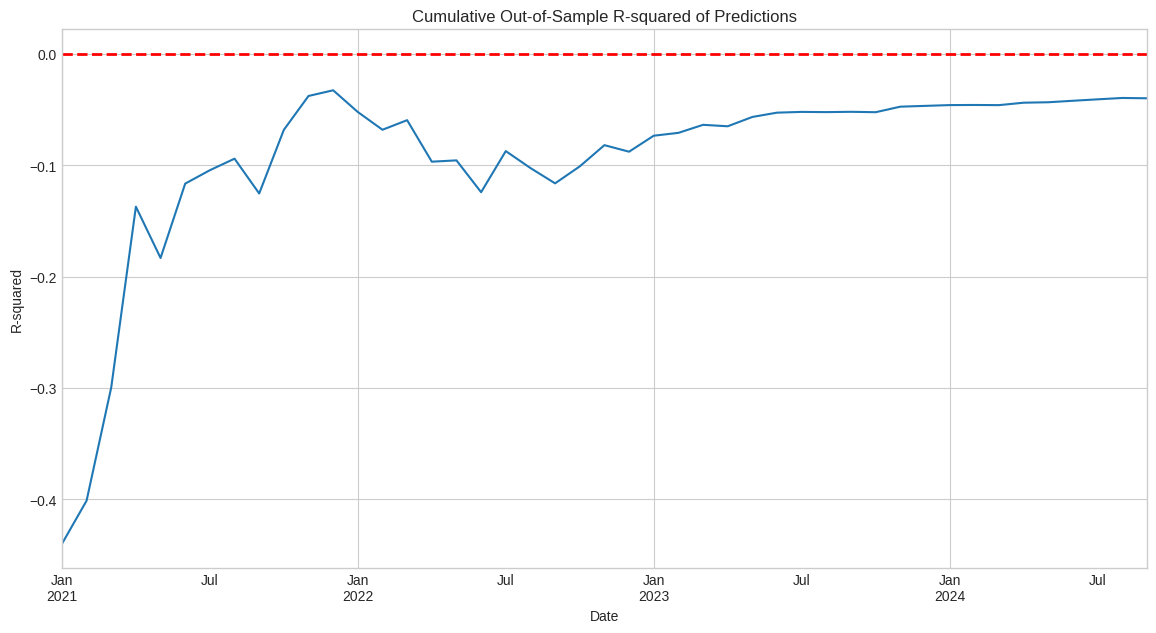

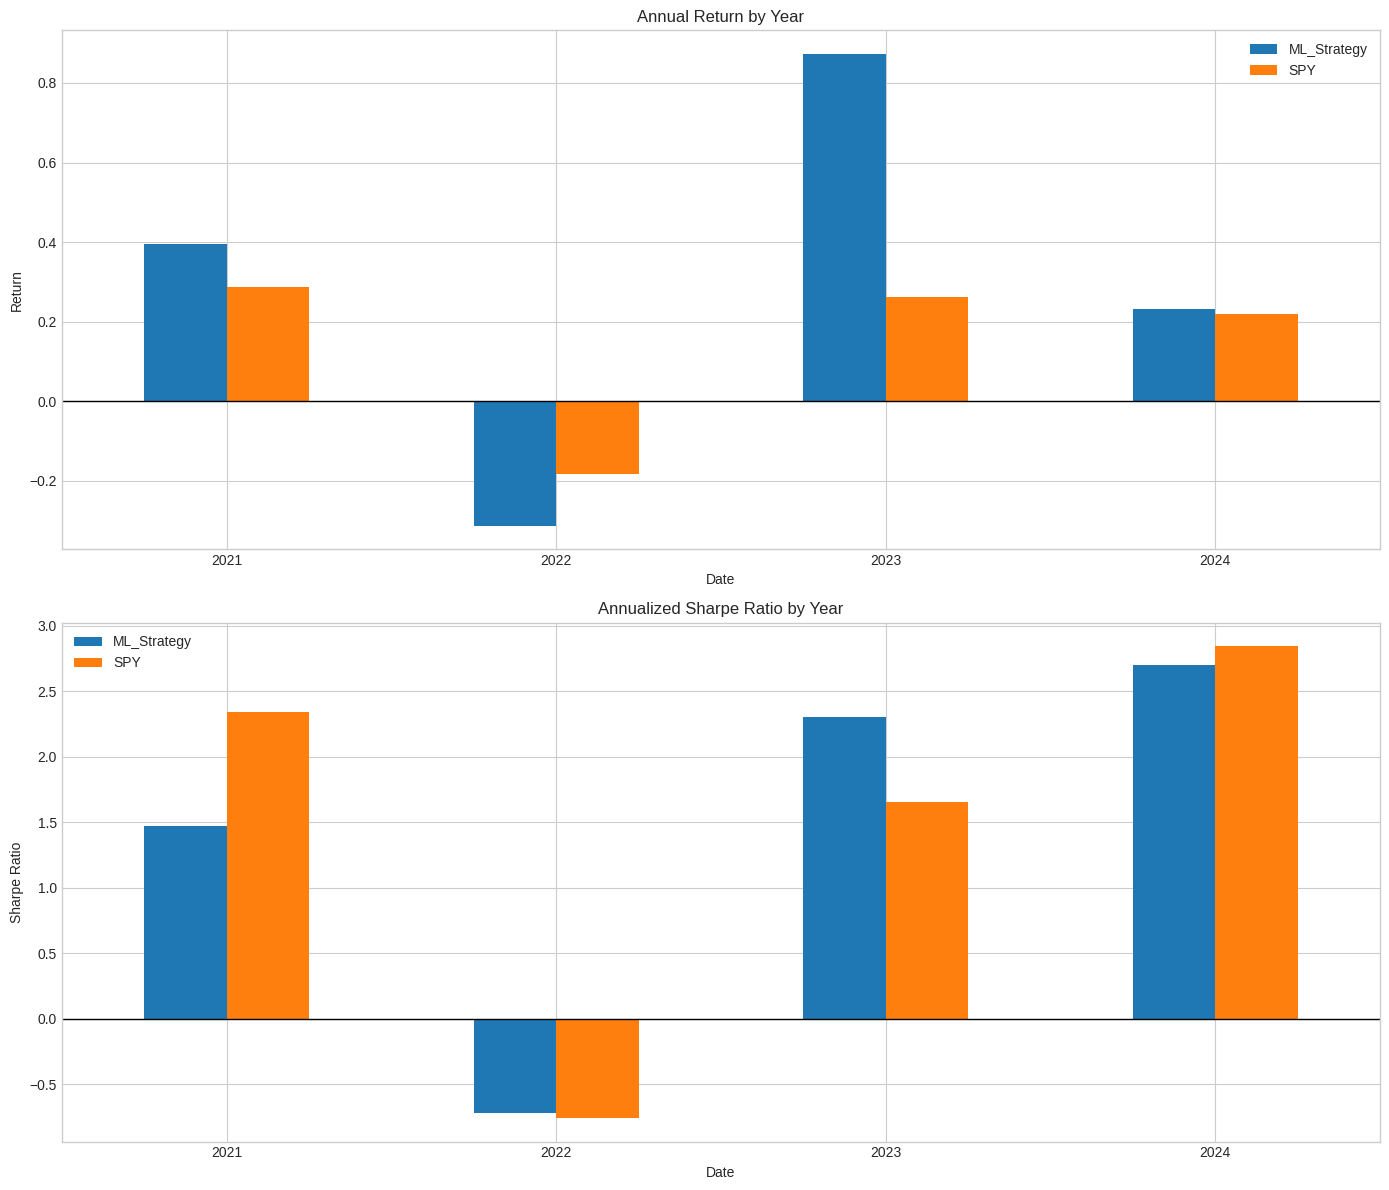

In [12]:
# ===================================================================
# --- 7.Plot Additional Charts as Required by the Project
# ===================================================================

def plot_oos_r_squared(predictions_df, actuals_df):
    """
    Calculate and plot the rolling out-of-sample R-squared.
    """
    # Convert wide format data to long format (Series) and remove missing values
    preds_series = predictions_df.stack(future_stack=True).dropna()
    actuals_series = actuals_df.stack(future_stack=True).dropna()

    # Align data
    common_index = preds_series.index.intersection(actuals_series.index)
    preds = preds_series.loc[common_index]
    actuals = actuals_series.loc[common_index]

    # Calculate R-squared
    sse = (actuals - preds).pow(2).cumsum() # Sum of Squared Errors
    sst = (actuals - actuals.expanding().mean()).pow(2).cumsum() # Total Sum of Squares

    # Avoid division by zero
    r_squared_oos = 1 - (sse / sst)
    r_squared_oos = r_squared_oos.dropna()

    # Extract time axis for plotting
    r_squared_oos.index = r_squared_oos.index.get_level_values(0)
    # Deduplicate by month, keeping the last value
    r_squared_oos = r_squared_oos.loc[~r_squared_oos.index.duplicated(keep='last')]

    # Plotting
    plt.figure(figsize=(14, 7))
    r_squared_oos.plot()
    plt.axhline(0, color='r', linestyle='--', lw=2)
    plt.title('Cumulative Out-of-Sample R-squared of Predictions')
    plt.ylabel('R-squared')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

def plot_annual_performance(results, training_window):
    """
    Plot comparative bar charts for annual returns and annual Sharpe ratios.
    """
    effective_results = results.iloc[training_window:].copy()
    returns_data = effective_results[['ML_Strategy', 'SPY']].dropna()

    # Calculate annual returns
    annual_returns = returns_data.groupby(returns_data.index.year).apply(lambda x: (1 + x).prod() - 1)

    # Calculate annual Sharpe ratios
    def annual_sharpe(returns):
        # Key fix: Removed the incorrect if statement. The calculation below will be done column-wise automatically.
        return (returns.mean() * 12) / (returns.std() * np.sqrt(12))

    # Add .fillna(0) after apply to handle any division by zero cases
    annual_sharpes = returns_data.groupby(returns_data.index.year).apply(annual_sharpe).fillna(0)

    # Plotting charts
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))

    # Annual Return Plot
    annual_returns.plot(kind='bar', ax=axes[0], grid=True)
    axes[0].set_title('Annual Return by Year')
    axes[0].set_ylabel('Return')
    axes[0].axhline(0, color='k', linestyle='-', lw=1)
    axes[0].tick_params(axis='x', rotation=0)

    # Annual Sharpe Plot
    annual_sharpes.plot(kind='bar', ax=axes[1], grid=True)
    axes[1].set_title('Annualized Sharpe Ratio by Year')
    axes[1].set_ylabel('Sharpe Ratio')
    axes[1].axhline(0, color='k', linestyle='-', lw=1)
    axes[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

# --- Call plotting functions ---
print("\n--- Plotting Additional Charts ---")
plot_oos_r_squared(predictions_df, actuals_df)
plot_annual_performance(backtest_results_ml, TRAIN_WINDOW)

In [13]:
# ===================================================================
# --- 8. Analyze Alpha and Beta
# ===================================================================

import statsmodels.api as sm

def analyze_alpha_beta(results, training_window):
    """
    Calculate the strategy's Alpha and Beta using the CAPM model.
    """
    effective_results = results.iloc[training_window:].copy().dropna()
    strategy_returns = effective_results['ML_Strategy']

    # Key fix: Now looks for the column named 'SPY'
    market_returns = effective_results['SPY']

    X = sm.add_constant(market_returns)
    y = strategy_returns

    model = sm.OLS(y, X).fit()

    alpha_monthly, beta = model.params
    alpha_annualized = (1 + alpha_monthly)**12 - 1

    print("\n--- Strategy Alpha & Beta Analysis (CAPM) ---\n")
    print(f"Strategy's Beta (vs. SPY): {beta:.4f}")
    print(f"Monthly Alpha: {alpha_monthly:.4%}")
    print(f"Annualized Alpha: {alpha_annualized:.4%}")
    print(f"R-squared: {model.rsquared:.4f}")
    print("\nRegression Model Summary:")
    print(model.summary())
    print("\n-------------------------------------\n")

# Call this function after obtaining backtest_results_ml
analyze_alpha_beta(backtest_results_ml, TRAIN_WINDOW)


--- Strategy Alpha & Beta Analysis (CAPM) ---

Strategy's Beta (vs. SPY): 1.3102
Monthly Alpha: 0.6083%
Annualized Alpha: 7.5488%
R-squared: 0.4985

Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:            ML_Strategy   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     42.74
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           6.03e-08
Time:                        11:45:42   Log-Likelihood:                 61.871
No. Observations:                  45   AIC:                            -119.7
Df Residuals:                      43   BIC:                            -116.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err  